In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import PIL
import numpy as np
from tqdm import tqdm_notebook as tqdm

import torch
from torch import Tensor
from torch.autograd import Variable
from torch import nn
from torch.optim import Adam, LBFGS
import torch.nn.functional as F

from torchvision.models import vgg19
import torchvision.transforms.functional as Fv
from torchvision import transforms

In [2]:
class FeatureExtractor(nn.Module):
    """Evaluates model layer-by-layer, extracting activations"""
    def __init__(self, net, idxs):
        super(FeatureExtractor, self).__init__()
        self.net = net
        self.idxs = idxs

    def forward(self, img, detach=False):
        out = img
        Fs = []
        for i, layer in enumerate(self.net.children()):
            if isinstance(layer, nn.ReLU):
                layer = nn.ReLU(inplace=False)
            if isinstance(layer, nn.MaxPool2d): # for better gradients
                layer = nn.AvgPool2d(layer.kernel_size)
            out = layer(out)
            if i in self.idxs:
                if detach:
                    out = out.detach()
                Fs.append(out)
            if i == self.idxs[-1]: # stop evalating model on last used layer
                break
        return Fs

In [3]:
class StyleTransfer(nn.Module):
    def __init__(self, img_size, style_extractor, style_weights, content_extractor, content_weights):
        super(StyleTransfer, self).__init__()
        self.style_extractor = style_extractor
        self.style_weights = style_weights
        self.content_extractor = content_extractor
        self.content_weights = content_weights
        self.img_size = img_size

        self.mean = nn.Parameter(Tensor([0.485, 0.456, 0.406]))
        self.std = nn.Parameter(Tensor([0.229, 0.224, 0.225]))

        self.style_img_F = None
        self.style_img_G = None
        self.content_img_F = None

    def compute_features(self, img, extractor, detach=False):
        # batch shape is assumed to be 1
        fs = extractor(img, detach)
        fs = [f.view(1, f.size(1), -1) for f in fs] # flatten width, height dimensions
        return fs

    def compute_gram_matrices(self, features, flatten=True):
        fs_sizes = [f.size(2) for f in features]

        gs = [torch.bmm(f, f.transpose(1, 2))/f_size for f, f_size in zip(features, fs_sizes)]
        if flatten:
            gs = [g.view(1, -1) for g in gs]
        return gs

    def extract_style(self, style_img):
        style_img = Fv.normalize(style_img, self.mean, self.std)[None]
        self.style_img_F = self.compute_features(style_img, self.style_extractor, detach=True)
        self.style_img_G = self.compute_gram_matrices(self.style_img_F)

    def extract_content(self, content_img):
        content_img = Fv.normalize(content_img, self.mean, self.std)[None]
        self.content_img_F = self.compute_features(content_img, self.content_extractor, detach=True)

    def forward(self, random_img):
        assert all((self.style_img_F, self.style_img_G, self.content_img_F)), 'you must provide style and content first'

        random_img = random_img - self.mean[:, None, None]
        random_img = random_img / self.std[:, None, None]
        random_img = random_img[None]

        # style
        random_img_F = self.compute_features(random_img, self.style_extractor)
        random_img_G = self.compute_gram_matrices(random_img_F)
        style_losses = [nn.MSELoss()(Gr, Gs)*u for Gs, Gr, u in zip(self.style_img_G, random_img_G, 
                                                                    self.style_weights)]
        L_style = sum(style_losses)
        L_style = L_style.view(-1)

        # content
        random_img_F = self.compute_features(random_img, self.content_extractor)
        content_losses = [nn.MSELoss()(Fr, Fc)*u for Fc, Fr, u in zip(self.content_img_F, random_img_F, 
                                                                   self.content_weights)]
        L_content = sum(content_losses)
        L_content = L_content.view(-1)
        return L_content, L_style

    def transform_from_pil(self, img_raw, size):
        img = Fv.to_tensor(Fv.resize(img_raw, size))
        if use_cuda:
            img = img.cuda()
        return img

    def transform_to_pil(self, img):
        img = img.detach()
        img.data.clamp_(0., 1.)
        img = Fv.to_pil_image(img.cpu())
        return img

    def transfer(self, content_img_raw, style_img_raw, n_iter, alpha, beta, size, print_every=50):
        content_img = self.transform_from_pil(content_img_raw, size)
        style_img   = self.transform_from_pil(style_img_raw, size)
        random_img = Variable(content_img.clone(), requires_grad=True)
#         random_img = Variable(torch.randn_like(content_img)/3 + 0.5, requires_grad=True)
        random_img.data.clamp_(0., 1.)

        self.extract_content(content_img)
        self.extract_style(style_img)

        optimizer = LBFGS([random_img]);
        itr = [0]
        while itr[0] <= n_iter:
            def closure():
                optimizer.zero_grad()
                Lc, Ls = self(random_img)
                Lc, Ls = Lc*alpha, Ls*beta
                loss = Lc + Ls
                if not itr[0] % print_every:
                    print("i: %d, loss: %5.3f, content_loss: %5.3f, style_loss: %5.3f" % (
                          itr[0], loss.item(), Lc.item(), Ls.item()))
                loss.backward()
                itr[0]+=1
                return loss
            optimizer.step(closure)
            random_img.data.clamp_(0., 1.)

        return self.transform_to_pil(random_img)

In [4]:
use_cuda = torch.cuda.is_available()
net = vgg19(pretrained=True).features.eval()
for p in net.parameters():
    p.requires_grad = False

In [5]:
style_idxs = [1, 6, 11, 20, 29] # indices of layers to use as style in sequential vgg.features
style_weights = [1, 1, 1, 1, 1]

content_idxs = [22] # indices of layers to use as content in sequential vgg.features
content_weights = [1]

i: 0, loss: 238.468, content_loss: 0.000, style_loss: 238.468
i: 50, loss: 1.387, content_loss: 0.584, style_loss: 0.803
i: 100, loss: 0.871, content_loss: 0.525, style_loss: 0.346
i: 150, loss: 0.705, content_loss: 0.495, style_loss: 0.210
i: 200, loss: 0.643, content_loss: 0.473, style_loss: 0.170


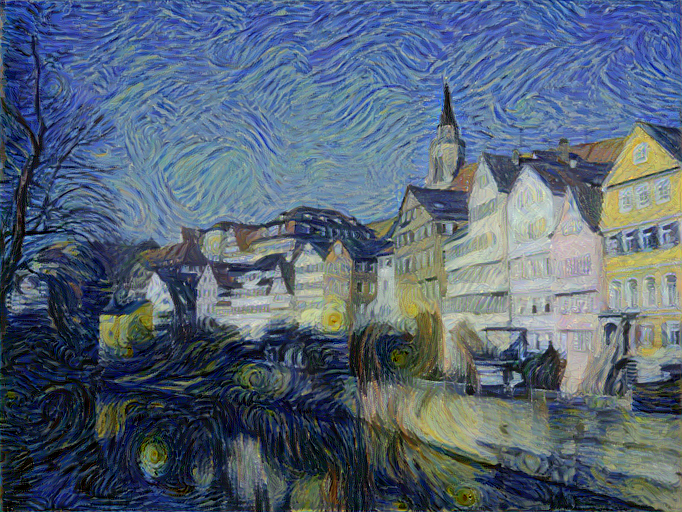

In [6]:
img_size = 512

style_extractor = FeatureExtractor(net, style_idxs)
content_extractor = FeatureExtractor(net, content_idxs)
style_transfer = StyleTransfer(img_size, style_extractor, style_weights, content_extractor, content_weights)

content = PIL.Image.open(f"images/content1.jpg")
style = PIL.Image.open(f"images/style2.jpg")

if use_cuda:
    style_transfer = style_transfer.cuda()

stylized_img = style_transfer.transfer(content, style, n_iter=200, alpha=1, beta=1e3, size=img_size)
stylized_img

In [7]:
from itertools import product

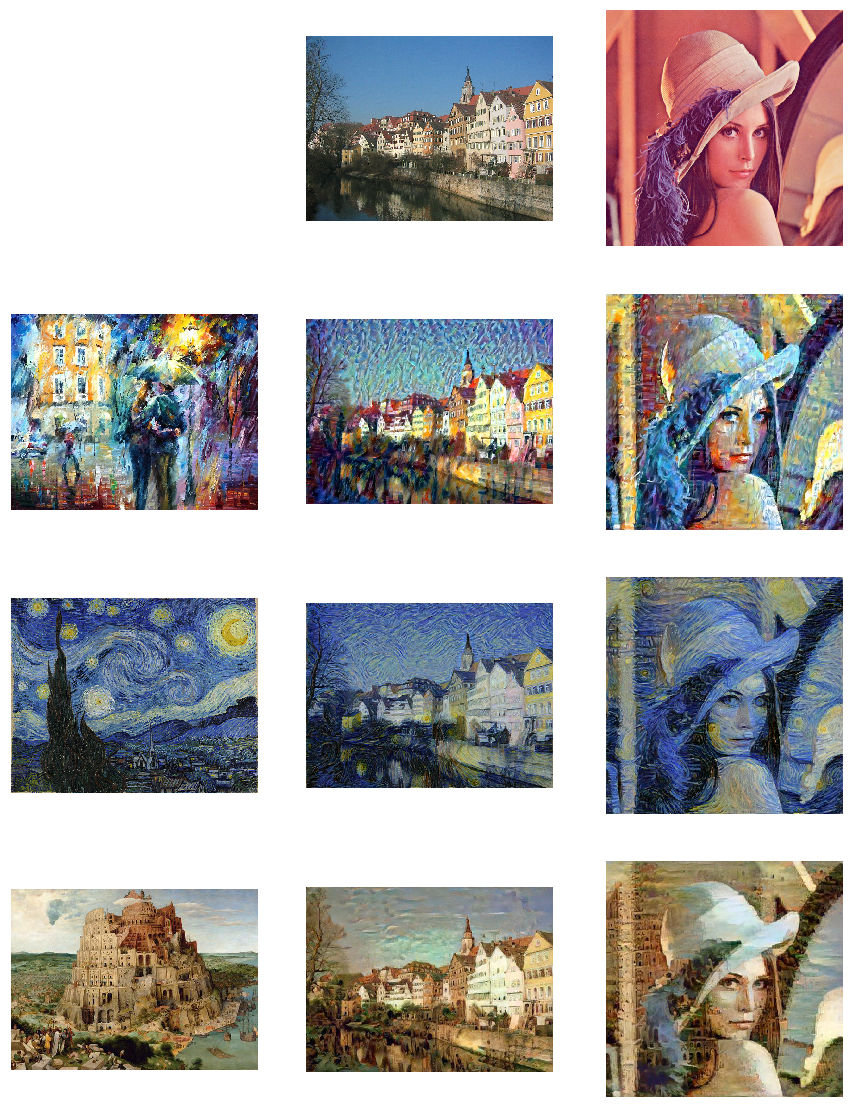

In [8]:
f, axes = plt.subplots(4, 3, figsize=(15, 20))
for i, j in product(range(4), range(3)):
    ax = axes[i][j]
    ax.set_axis_off()
    if i == j == 0:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.patch.set_visible(False)
        continue
    if i == 0:
        img_name = f"content{j}"
    elif j == 0:
        img_name = f"style{i}"
    else:
        img_name = f"result{j}{i}"

#     axis.grid = False
    img = PIL.Image.open(open("images/" + img_name + ".jpg", "rb"))
    ax.imshow(img)
    ax.patch.set_visible(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# plt.figure()
plt.show()